In [ ]:

import pandas as pd
import random
import openai
import chardet
import re
import time
import tiktoken
from ast import literal_eval
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm
from openai.error import RateLimitError, APIError
encoding = tiktoken.encoding_for_model("text-embedding-3-small")
MAX_TOKENS = 8000


c:\Users\JOSUE\Downloads\SentimentML_TEST\SentimentMLTEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_1 = pd.read_parquet("processed.parquet")


In [3]:
# True si en alguna fila sigue habiendo un string en vez de lista o array
has_strings = df_1['embedding'].apply(lambda x: isinstance(x, str)).any()
print("¿Hay embeddings como strings?", has_strings)

¿Hay embeddings como strings? False


In [4]:
import numpy as np
# This turns the list‑of‑floats in each row into a proper 2D array
X = np.vstack(df_1['embedding'].values) 

In [ ]:
from sklearn.preprocessing import normalize
# 3. Normalizar con norma L2
#Prepares data for better clustering (unit-length vectors)
X_norm = normalize(X, norm='l2')  # Cada vector tiene longitud 1

In [6]:
import matplotlib.pyplot as plt

# The elbow method to check and determine in how many clusters we should cluster the data
def optimise_kmeans(data, max_k):
    means = []	
    inertia = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertia.append(kmeans.inertia_)
    
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(means, inertia, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

sil_scores = []
sample_size = 5000  # ajusta según tu RAM

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42,n_init=10)
    labels = km.fit_predict(X_norm)
    
    # Sample para silhouette
    X_sample, labels_sample = resample(X_norm, labels, n_samples=sample_size, random_state=42)
    score = silhouette_score(X_sample, labels_sample)
    sil_scores.append(score)
    print(f"Silhouette score for k={k}: {score:.4f}")

Silhouette score for k=2: 0.1507
Silhouette score for k=3: 0.1676
Silhouette score for k=4: 0.1884
Silhouette score for k=5: 0.2090
Silhouette score for k=6: 0.1369
Silhouette score for k=7: 0.1367
Silhouette score for k=8: 0.1454
Silhouette score for k=9: 0.1520
Silhouette score for k=10: 0.1598


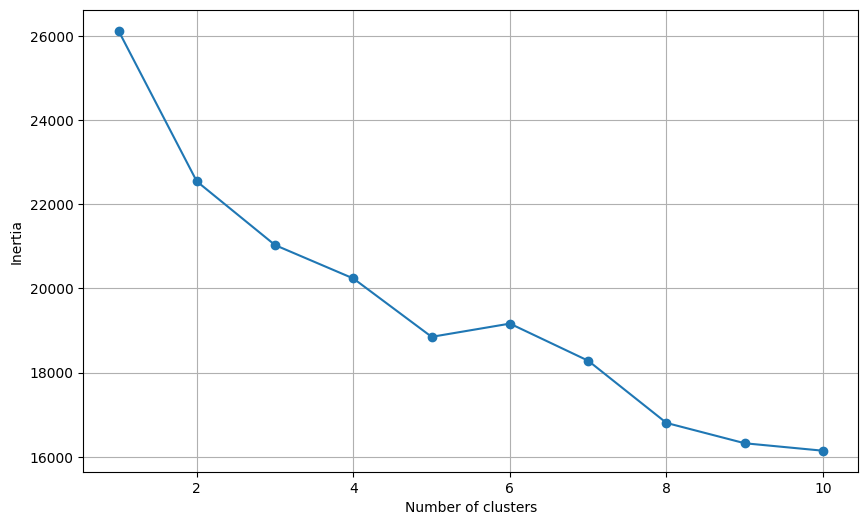

In [12]:
optimise_kmeans(X_norm, max_k=11)

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_norm)  

df_1['cluster'] = labels


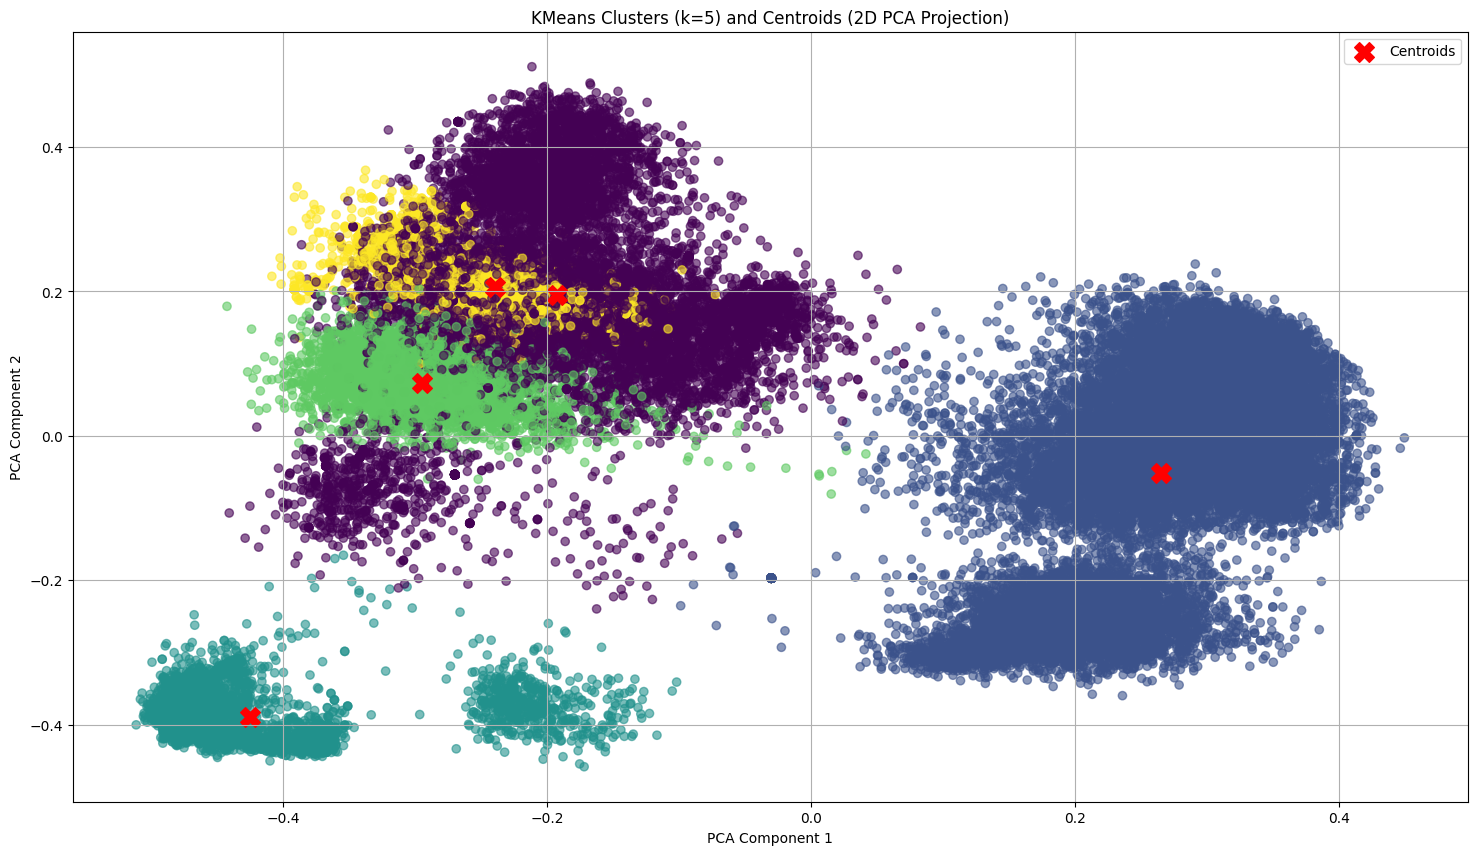

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for plotting
pca = PCA(n_components=2, random_state=42)
X_2D = pca.fit_transform(X_norm)
centroids_2D = pca.transform(kmeans.cluster_centers_)

# Plotting
plt.figure(figsize=(18, 10))
scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='viridis', alpha=0.6)# cmap='tab10',s=10,
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.title('KMeans Clusters (k=5) and Centroids (2D PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


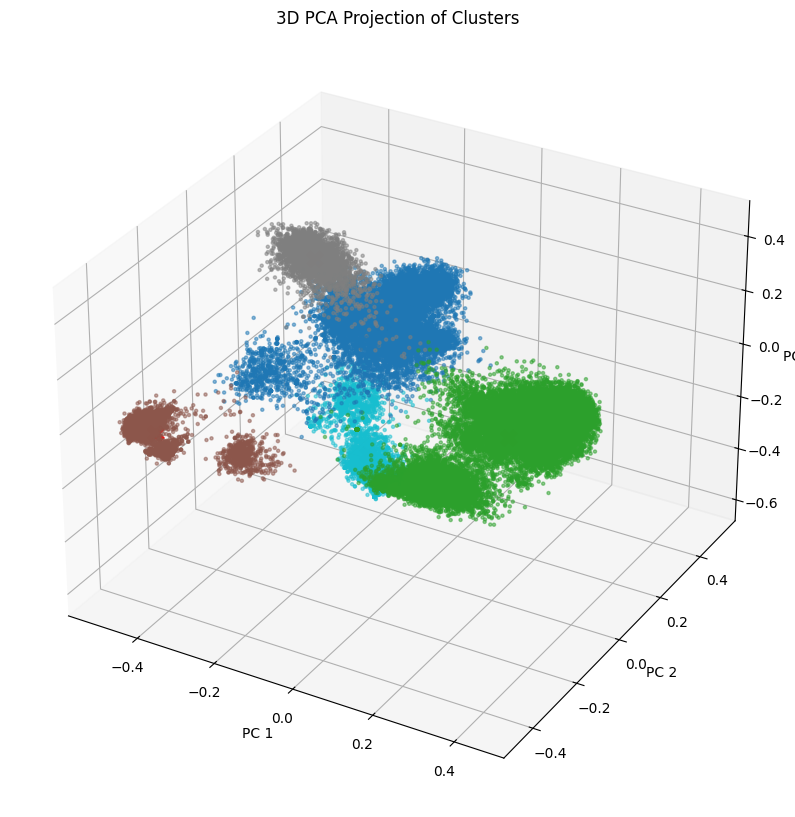

In [28]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Project your data to 3D using PCA
pca_3d = PCA(n_components=3)
X_pca_3D = pca_3d.fit_transform(X_norm)
centroids_3D = pca_3d.transform(kmeans.cluster_centers_)

# Plot
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3D[:, 0], X_pca_3D[:, 1], X_pca_3D[:, 2], c=labels, cmap='tab10', s=5, alpha=0.5)
ax.scatter(centroids_3D[:, 0], centroids_3D[:, 1], centroids_3D[:, 2], c='red', marker='X', s=150, )

ax.set_title("3D PCA Projection of Clusters")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
#ax.legend()
plt.show()


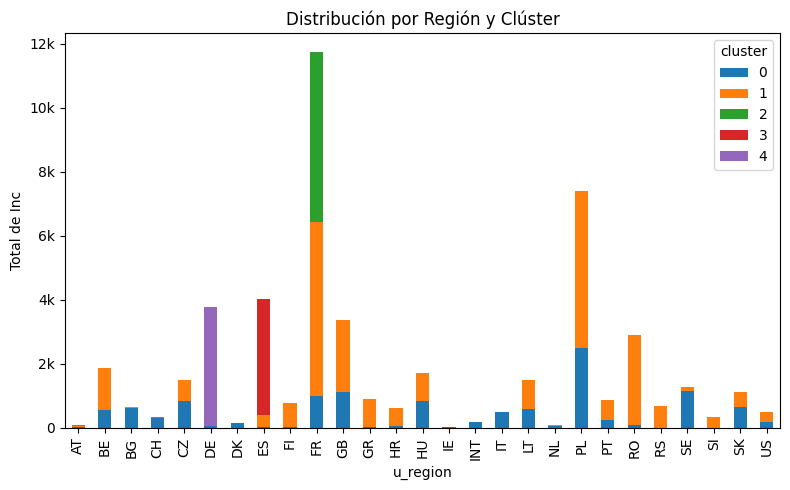

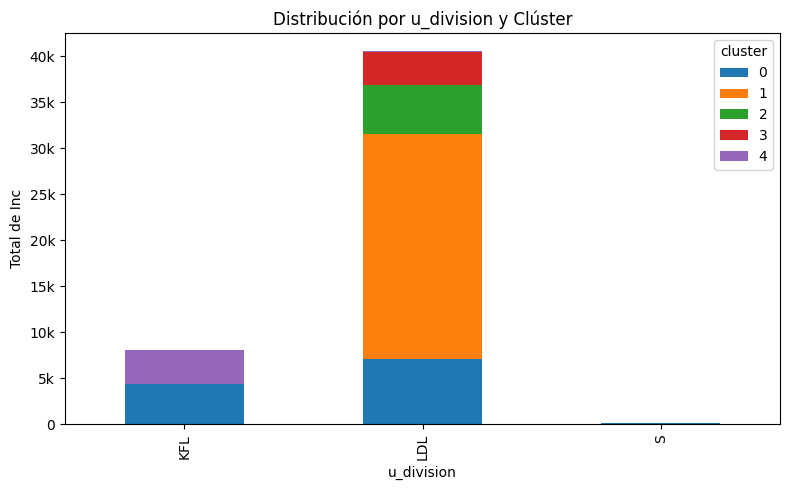

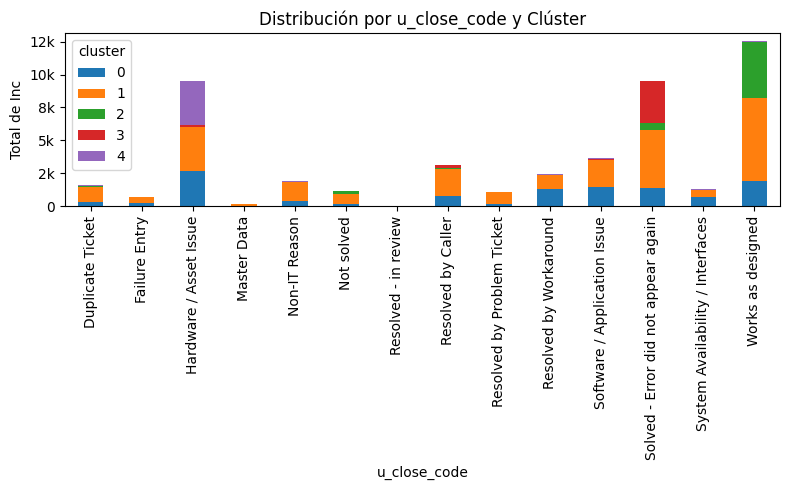

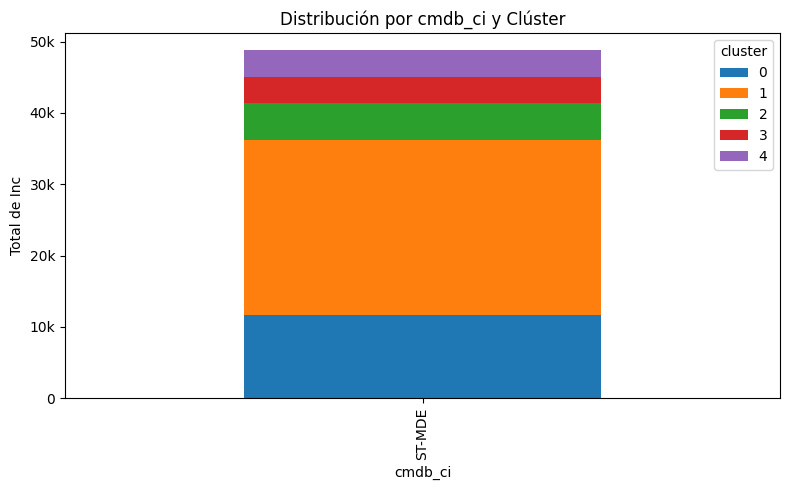

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x*1.0e-6:.0f}M'
    elif x >= 1_000:
        return f'{x*1.0e-3:.0f}k'
    else:
        return f'{int(x)}'

# Apply to first plot
ax = pd.crosstab(df_1['u_region'], df_1['cluster'])\
  .plot(kind='bar', stacked=True, figsize=(8,5), title='Distribución por Región y Clúster')
ax.set_ylabel('Total de Inc')
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.tight_layout()
plt.show()

# Apply to other plots
for col in ['u_division', 'u_close_code', 'cmdb_ci']:
    ax = pd.crosstab(df_1[col], df_1['cluster'])\
      .plot(kind='bar', stacked=True, figsize=(8,5), title=f'Distribución por {col} y Clúster')
    ax.set_ylabel('Total de Inc')
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.tight_layout()
    plt.show()


In [31]:
# unique incident count per cluster
inc_count = df_1.groupby('cluster')['number'].nunique()
print(inc_count)

cluster
0    11689
1    24450
2     5310
3     3621
4     3720
Name: number, dtype: int64


In [19]:
# 👀 6. Inspect each cluster manually
for i in range(n_clusters):
    print(f"\n🔹 Cluster {i}:")
    print(df_1[df_1['cluster'] == i]['clean_desc'].head(5).to_string(index=False))


🔹 Cluster 0:
here we have exactly the same incident as it is...
the mobile device on store warehouse is locked ...
mobile device locked in landscape mode since th...
since the android update on the honeywell devic...
maa fi myym l no l nsisatamankatu helsinki puhe...

🔹 Cluster 1:
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...
this ticket was created by a store employee sto...

🔹 Cluster 2:
lidl exp dition priorit j type avec change gest...
lidl exp dition type simple priorit j gestion c...
lidl exp dition priorit j type avec change gest...
lidl exp dition priorit j type avec change gest...
lidl exp dition priorit j type avec change gest...

🔹 Cluster 3:
incidencia en dispositivo terminal contacto car...
hello we have the same incident in at least fou...
forward to s int it siam support user nascimien...
user miguel ngel ivorra mi

In [28]:
df_1 = pd.read_csv("With_clusters_nameOPENAI.csv")

In [32]:
def categorize_and_explain_cluster(descriptions):
    
    sample_size = min(20, len(descriptions))

    # Randomly select 'sample_size' reviews from the cluster
    random_sample = random.sample(descriptions, sample_size)
    #text_sample = "\n".join(random_sample)
    text_sample = "\n".join(f"- {desc}" for desc in random_sample)  # bullet format improves clarity
    # Create a prompt for the model
    # Structured and clear prompt
    prompt = (
        "You are **ClusterNameBot**, an ITSM Reporting Assistant for ServiceNow.\n\n"  
        "Your job is to look at a batch of ticket descriptions all belonging to the same cluster and give that cluster.\n\n"
        "Here are 20 sample product descriptions from a single cluster:\n\n"
        f"{text_sample}\n\n"
        "Please do the following:\n"
        "1. Assign a **short, descriptive title** for this cluster (2-5 words max).\n"
        "2. Give a brief explanation of **why** you chose this title, highlighting any recurring themes, languague  or keywords.\n\n"
        "Avoid generic names like 'Cluster 1' or 'Miscellaneous'. Make the title informative.\n\n"
        "**Format your output as:**\n"
        "Title: <your title>\n"
        "Explanation: <your reasoning>"
    )
    
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini-2024-07-18",  # Latest model as requested
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
    )
    
    return response.choices[0].message.content

In [33]:
# Dictionary to hold each cluster's summary and explanation
cluster_summaries = {}

for cluster_label in sorted(df_1['cluster'].unique()):
    # Get all reviews for this cluster as a list
    descriptions = df_1[df_1['cluster'] == cluster_label]['clean_desc'].tolist()
    summary = categorize_and_explain_cluster(descriptions)
    cluster_summaries[cluster_label] = summary
    print(f"\nCluster {cluster_label} Summary and Explanation:\n")
    print(summary) 


Cluster 0 Summary and Explanation:

Title: Honeywell Device Issues

Explanation: This title was chosen because the majority of the ticket descriptions focus on problems related to various Honeywell devices, particularly issues with logging in, connectivity, and hardware malfunctions. Keywords such as "Honeywell," "problem description," and specific issues like "not possible to log in" and "device cannot connect" recur throughout the descriptions. The presence of specific device types like "PDA" and "scanner" further emphasizes that the cluster revolves around technical challenges faced with Honeywell equipment.

Cluster 1 Summary and Explanation:

Title: **Mobile Device Issues**

Explanation: The ticket descriptions consistently refer to problems encountered by store employees with mobile devices, specifically Honeywell and Zebra devices. Common themes include connectivity issues, device malfunctions, battery problems, and application errors. The recurring mention of "mobile office," 

In [ ]:
cluster_names = {
    0: "Device Connectivity Issues",
    1: "Store Support Incident Reports",
    2: "Honeywell PDA Support Issues",
    3: "PDA and Modem Issues",
    4: "MDE Device Malfunctions",
}

# new column with descriptive cluster names
df_1['cluster_name'] = df_1['cluster'].map(cluster_names)



# Save the updated DataFrame with descriptive names to CSV
df_1.to_csv("With_clusters_nameOPENAI.csv", index=False)

In [23]:
df = pd.read_csv('With_clusters_nameOPENAI.csv')
df.head(10) 

,number,short_description,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num,embedding,cluster,cluster_name
0,INC6658799,Mobile Office | My error is not listed / repor...,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee st...,3,[-0.0403446 0.02698302 0.03903169 ... -0.00...,1,Store Support Incident Reports
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as it i...,3,[-0.00832309 0.01956657 0.02247426 ... -0.01...,0,Device Connectivity Issues
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,FR,LDL,ST-MDE,Works as designed,the mobile device on store warehouse is locked...,3,[-0.00748125 0.03639196 -0.00684808 ... 0.02...,0,Device Connectivity Issues
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,FR,LDL,ST-MDE,Works as designed,mobile device locked in landscape mode since t...,3,[ 0.00082549 0.02529703 0.03505411 ... 0.02...,0,Device Connectivity Issues
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,FR,LDL,ST-MDE,Works as designed,since the android update on the honeywell devi...,3,[-0.04337902 0.01684821 0.01982284 ... -0.00...,0,Device Connectivity Issues
5,INC7255265,2659 - MUZILLAC - DR07 - INP MOBI # S/N : 2117...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,2,[-0.00512237 0.03671644 0.011913 ... -0.01...,2,Honeywell PDA Support Issues
6,INC7300612,0530 - CLERMONT-FERRAND - DR12 - MoBi - perdu ...,FR,LDL,ST-MDE,Works as designed,lidl exp dition type simple priorit j gestion ...,3,[-0.01646094 0.02828854 0.01656456 ... -0.01...,2,Honeywell PDA Support Issues
7,INC7337800,1090 - Lidl-Store: PARIS - DR10 - Mobi - aucun...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[-0.0084793 0.04281595 0.01367773 ... -0.01...,2,Honeywell PDA Support Issues
8,INC7345428,3930 - Lidl-Store: BAGNOLET - DR10 - Mobi - Pr...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[ 0.0257046 0.04382202 0.010591 ... -0.01...,2,Honeywell PDA Support Issues
9,INC7350179,1155 - ST GERMAIN VILLAGE Lisieux - DR11 -...,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit j type avec change ges...,3,[-0.00625989 0.02914764 0.02187954 ... -0.01...,2,Honeywell PDA Support Issues
